In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
from torch.autograd import Variable
import torch
import random

sys.path.append('../visualization')
sys.path.append('../acd/util')
sys.path.append('../acd/scores')
sys.path.append('../acd/agglomeration')
import agg_2d as agg
import viz_2d as viz

# load the model and dset

In [2]:
# load the dataset
sys.path.append('../dsets/mnist')
import dset
im_torch, im_orig, label = dset.get_im_and_label(250) # this will download the mnist dataset


# load the model
model = dset.Net().cuda()
model.load_state_dict(torch.load('../dsets/mnist/mnist.model'))
model.eval()

Net(
  (conv1): Conv2d (1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50)
  (fc2): Linear(in_features=50, out_features=10)
)

In [3]:
def attack_im_num(dset, model, im_num, attack_type):
    # seed
    np.random.seed(13)
    random.seed(13)
    torch.manual_seed(13)
    
    im_torch, im_orig, label = dset.get_im_and_label(im_num)
    pix_min = np.min(im_torch.data.cpu().numpy())
    pix_max = np.max(im_torch.data.cpu().numpy())
    fmodel = foolbox.models.PyTorchModel(model, bounds=(pix_min-1, pix_max+1), 
                                         num_classes=10, channel_axis=1)
    if attack_type == 'saliency':
        attack = foolbox.attacks.SaliencyMapAttack(fmodel) # saliency map attack has some good stuff
    elif attack_type == 'fgsm':
        attack = foolbox.attacks.FGSM(fmodel) # saliency map attack has some good stuff
    elif attack_type == 'gradientattack':
        attack = foolbox.attacks.GradientAttack(fmodel) # saliency map attack has some good stuff
    elif attack_type == 'deepfoolattack':
        attack = foolbox.attacks.DeepFoolAttack(fmodel) # saliency map attack has some good stuff
    elif attack_type == 'boundaryattack':
        attack = foolbox.attacks.BoundaryAttack(fmodel) # saliency map attack has some good stuff

    if attack_type == 'boundaryattack':
        im_orig_adv = attack(im_torch.data.cpu().numpy()[0], label, log_every_n_steps=10000)
    else:
        im_orig_adv = attack(im_torch.data.cpu().numpy()[0], label)

    # # set up vars
    im_torch_adv = Variable(torch.from_numpy(np.expand_dims(im_orig_adv, 0)).cuda(), requires_grad=True)
    im_orig_adv = im_orig_adv[0] # make this 28 x 28
    
    # see preds
    pred_orig = model(im_torch).exp().data.cpu().numpy().flatten()
    pred_adv = model(im_torch_adv).exp().data.cpu().numpy().flatten()
    targets = np.argsort(pred_adv)
    target = targets[-1]
    if target == label:
        target = targets[-2]
    
    return im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv

# s4 - plot adversarial attacks

run with verbose=True to see details
Step 0: 9.18581e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 3460: 2.58903e-03, stepsizes = 1.5e-05/7.8e-08: 
Step 3571: 2.58903e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 3572: 2.58903e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 3573: 2.58903e-03, stepsizes = 4.5e-06/5.2e-08: 
Step 3574: 2.58903e-03, stepsizes = 4.5e-06/5.2e-08: 
Step 3575: 2.58903e-03, stepsizes = 3.0e-06/3.5e-08: 
Step 3576: 2.58903e-03, stepsizes = 3.0e-06/3.5e-08: 
Step 3577: 2.58903e-03, stepsizes = 3.0e-06/3.5e-08: 
Step 3578: 2.58903e-03, stepsizes = 3.0e-06/3.5e-08: 
Step 3579: 2.58903e-03, stepsizes = 2.0e-06/2.3e-08: 
Step 3580: 2.58903e-03, stepsizes = 2.0e-06/2.3e-08: 
Step 3581: 2.58903e-03, stepsizes = 2.0e-06/2.3e-08: 
Step 3582: 2.58903e-03, stepsizes = 2.0e-06/2.3e-08: 
Step 3583: 2.58903e-03, stepsizes = 1.3e-06/1.5e-08: 
Step 3584: 2.58903e-03, stepsizes = 1.3e-06/1.5e-08: 
Step 3585: 2.58903e-03, stepsizes = 1.3e-06/1.5e-08: 
Step 3586: 2.58903e-03, stepsizes = 1.3e-06/1.5e

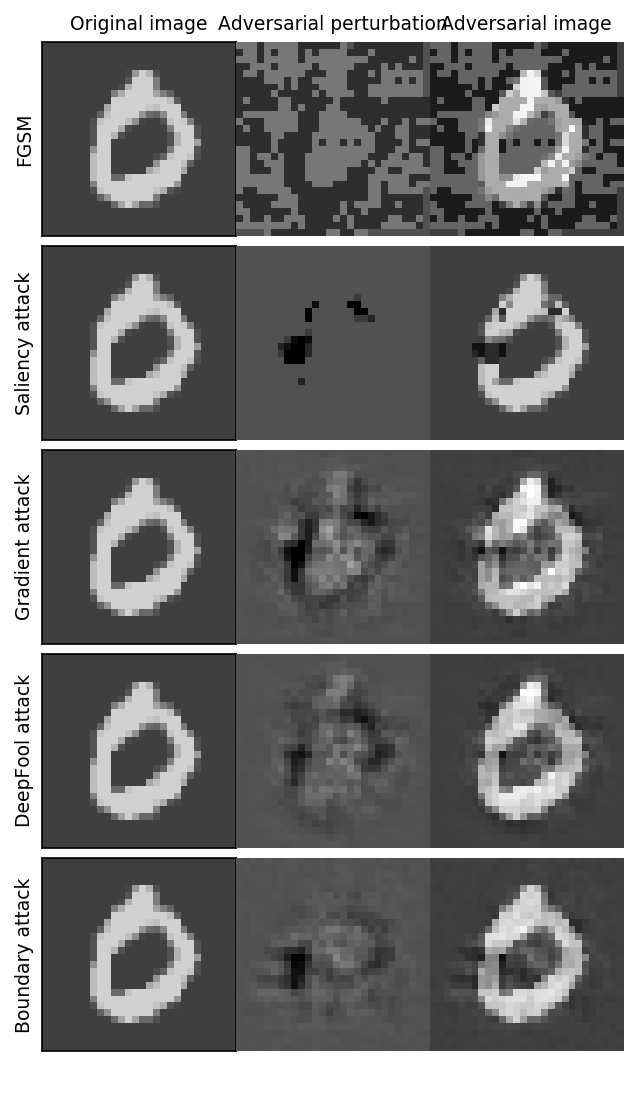

In [7]:
# attack image in several ways
im_num = 3
ats = ['fgsm', 'saliency', 'gradientattack', 'deepfoolattack', 'boundaryattack']
vals = []
for attack_type in ats:
    im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv = attack_im_num(dset, model, im_num, attack_type)
    vals.append((im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv))


plt.figure(figsize=(5, 9), dpi=150)
num_rows = 5
num_cols = 3
titsize = 9
labsize = 9
att_names = ['FGSM', 'Saliency attack', 'Gradient attack', 'DeepFool attack', 'Boundary attack']

# find min and max
vmin = 1000
vmax = 0
for i, attack_type in enumerate(ats):
    (im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv) = vals[i]
    vmi = min([np.min(im) for im in [im_orig, im_orig_adv, im_orig - im_orig_adv]])
    vma = max([np.max(im) for im in [im_orig, im_orig_adv, im_orig - im_orig_adv]])
    vmin = min(vmi, vmin)
    vmax = max(vma, vmax)

# plot
for i, attack_type in enumerate(ats):
    (im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv) = vals[i]

    plt.subplot(num_rows, num_cols, num_cols * i + 1)
    plt.imshow(im_orig, cmap='gray', vmin=vmin, vmax=vmax)
    plt.gca().xaxis.set_visible(False)
    plt.gca().yaxis.set_ticks([])
    if i == 0:
        plt.title('Original image', fontsize=titsize)
    plt.ylabel(att_names[i], fontsize=labsize)

    plt.subplot(num_rows, num_cols, num_cols * i + 2)
    plt.imshow(im_orig_adv - im_orig, cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    if i == 0:
        plt.title('Adversarial perturbation', fontsize=titsize)
        
    plt.subplot(num_rows, num_cols, num_cols * i + 3)
    plt.imshow(im_orig_adv, cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    if i == 0:
        plt.title('Adversarial image', fontsize=titsize)
    print('\tlabel:', label, pred_orig[label], '->', pred_adv[label])
    print('\ttarget:', target, pred_orig[target], '->', pred_adv[target])        

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# s3 - plot adv agg examples

../acd/agglomeration/agg_2d.py:60: RuntimeWarning: invalid value encountered in greater_equal
  im_thresh = np.logical_and(scores >= thresh, ~np.isnan(scores))


Original image


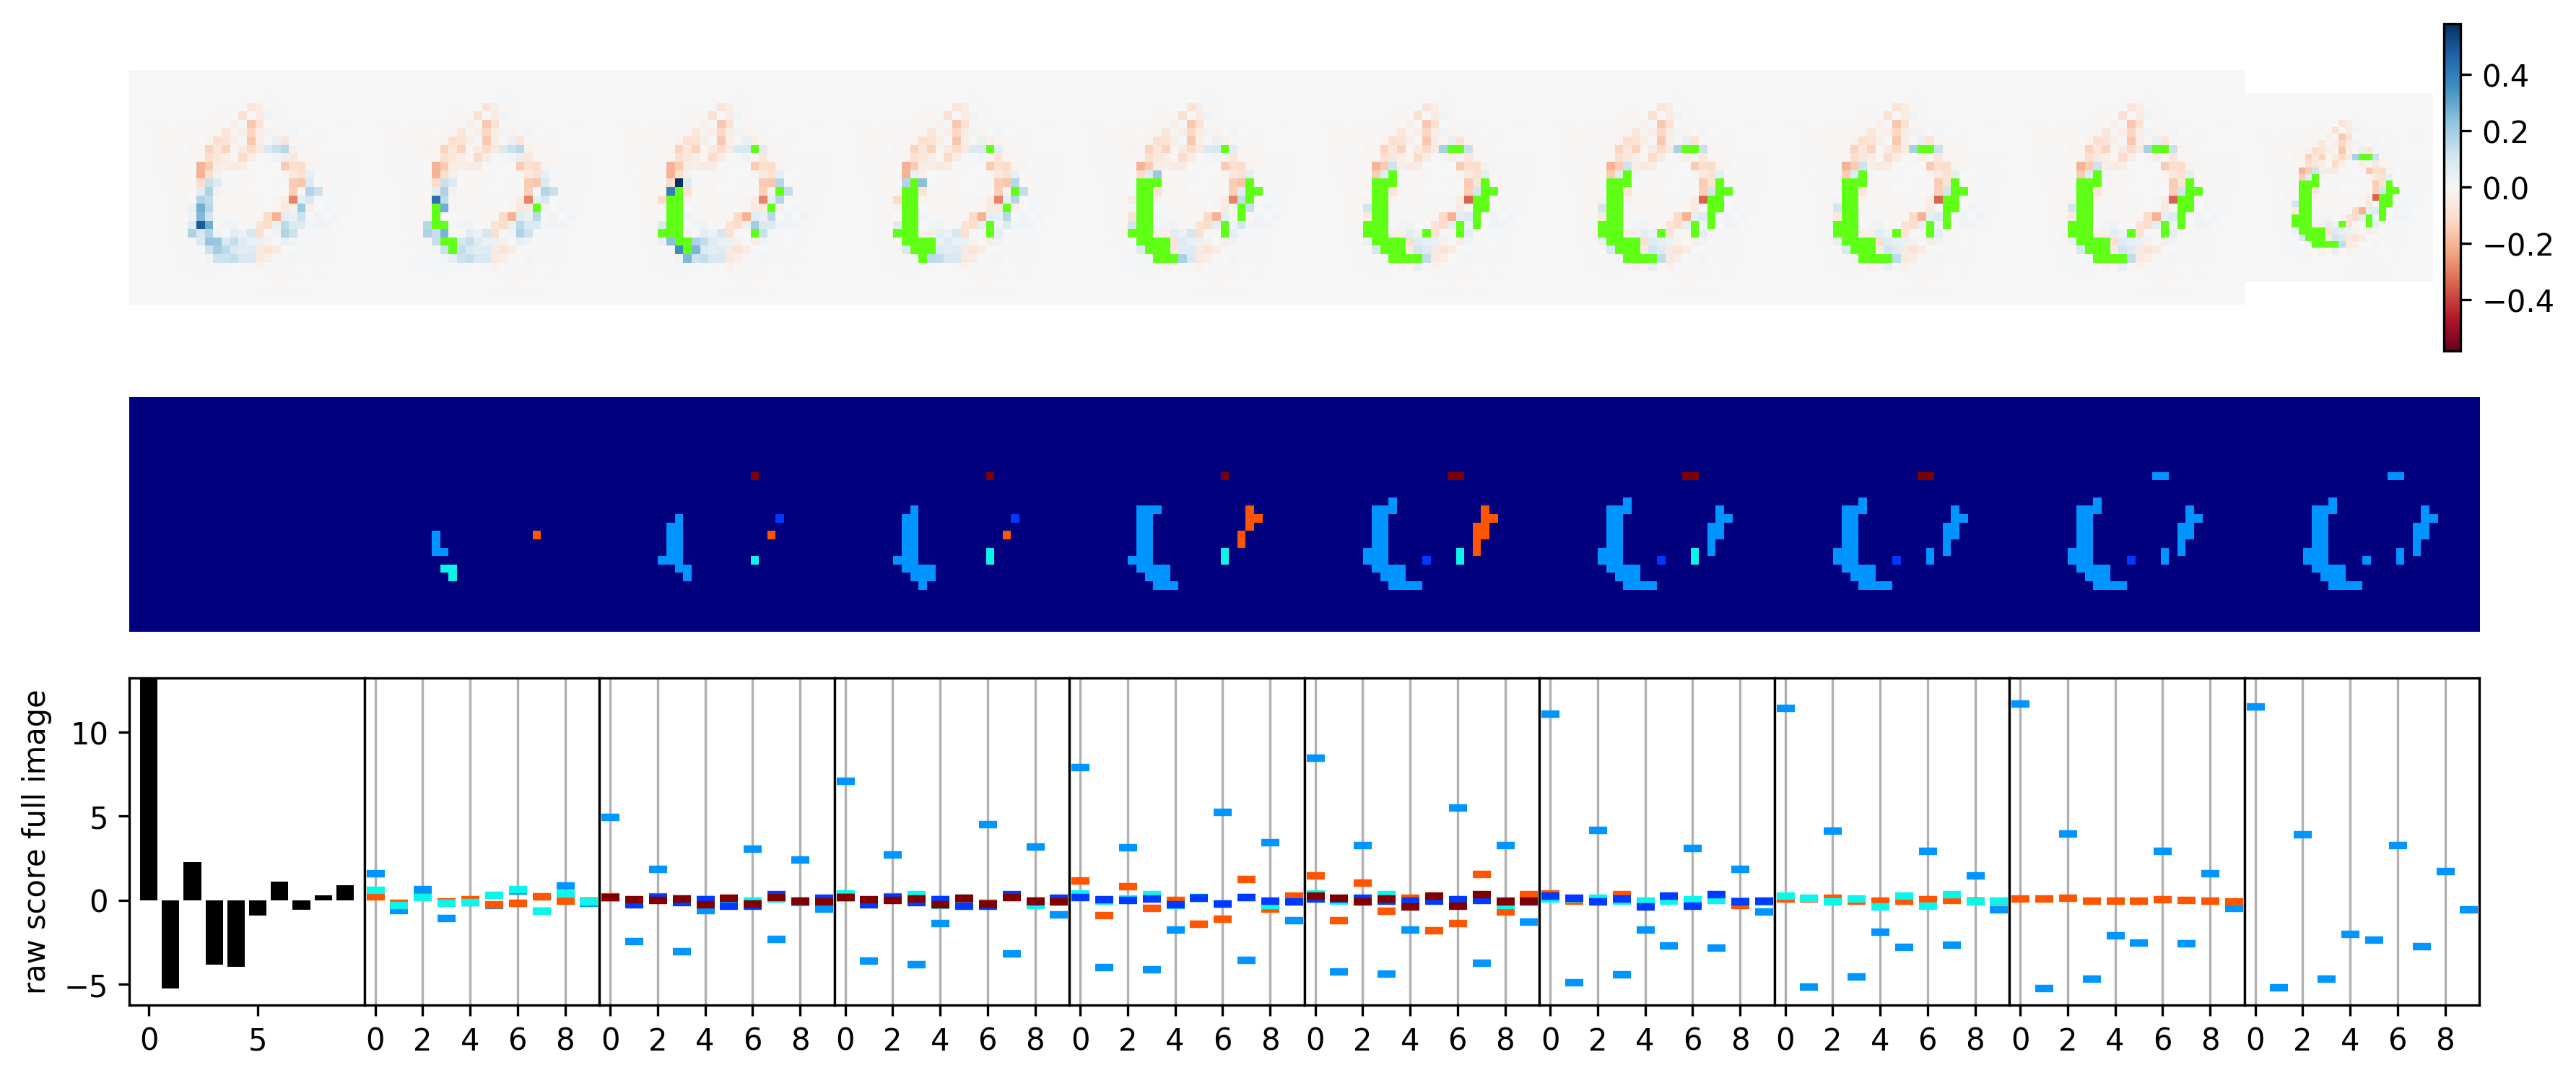

Adversarial image


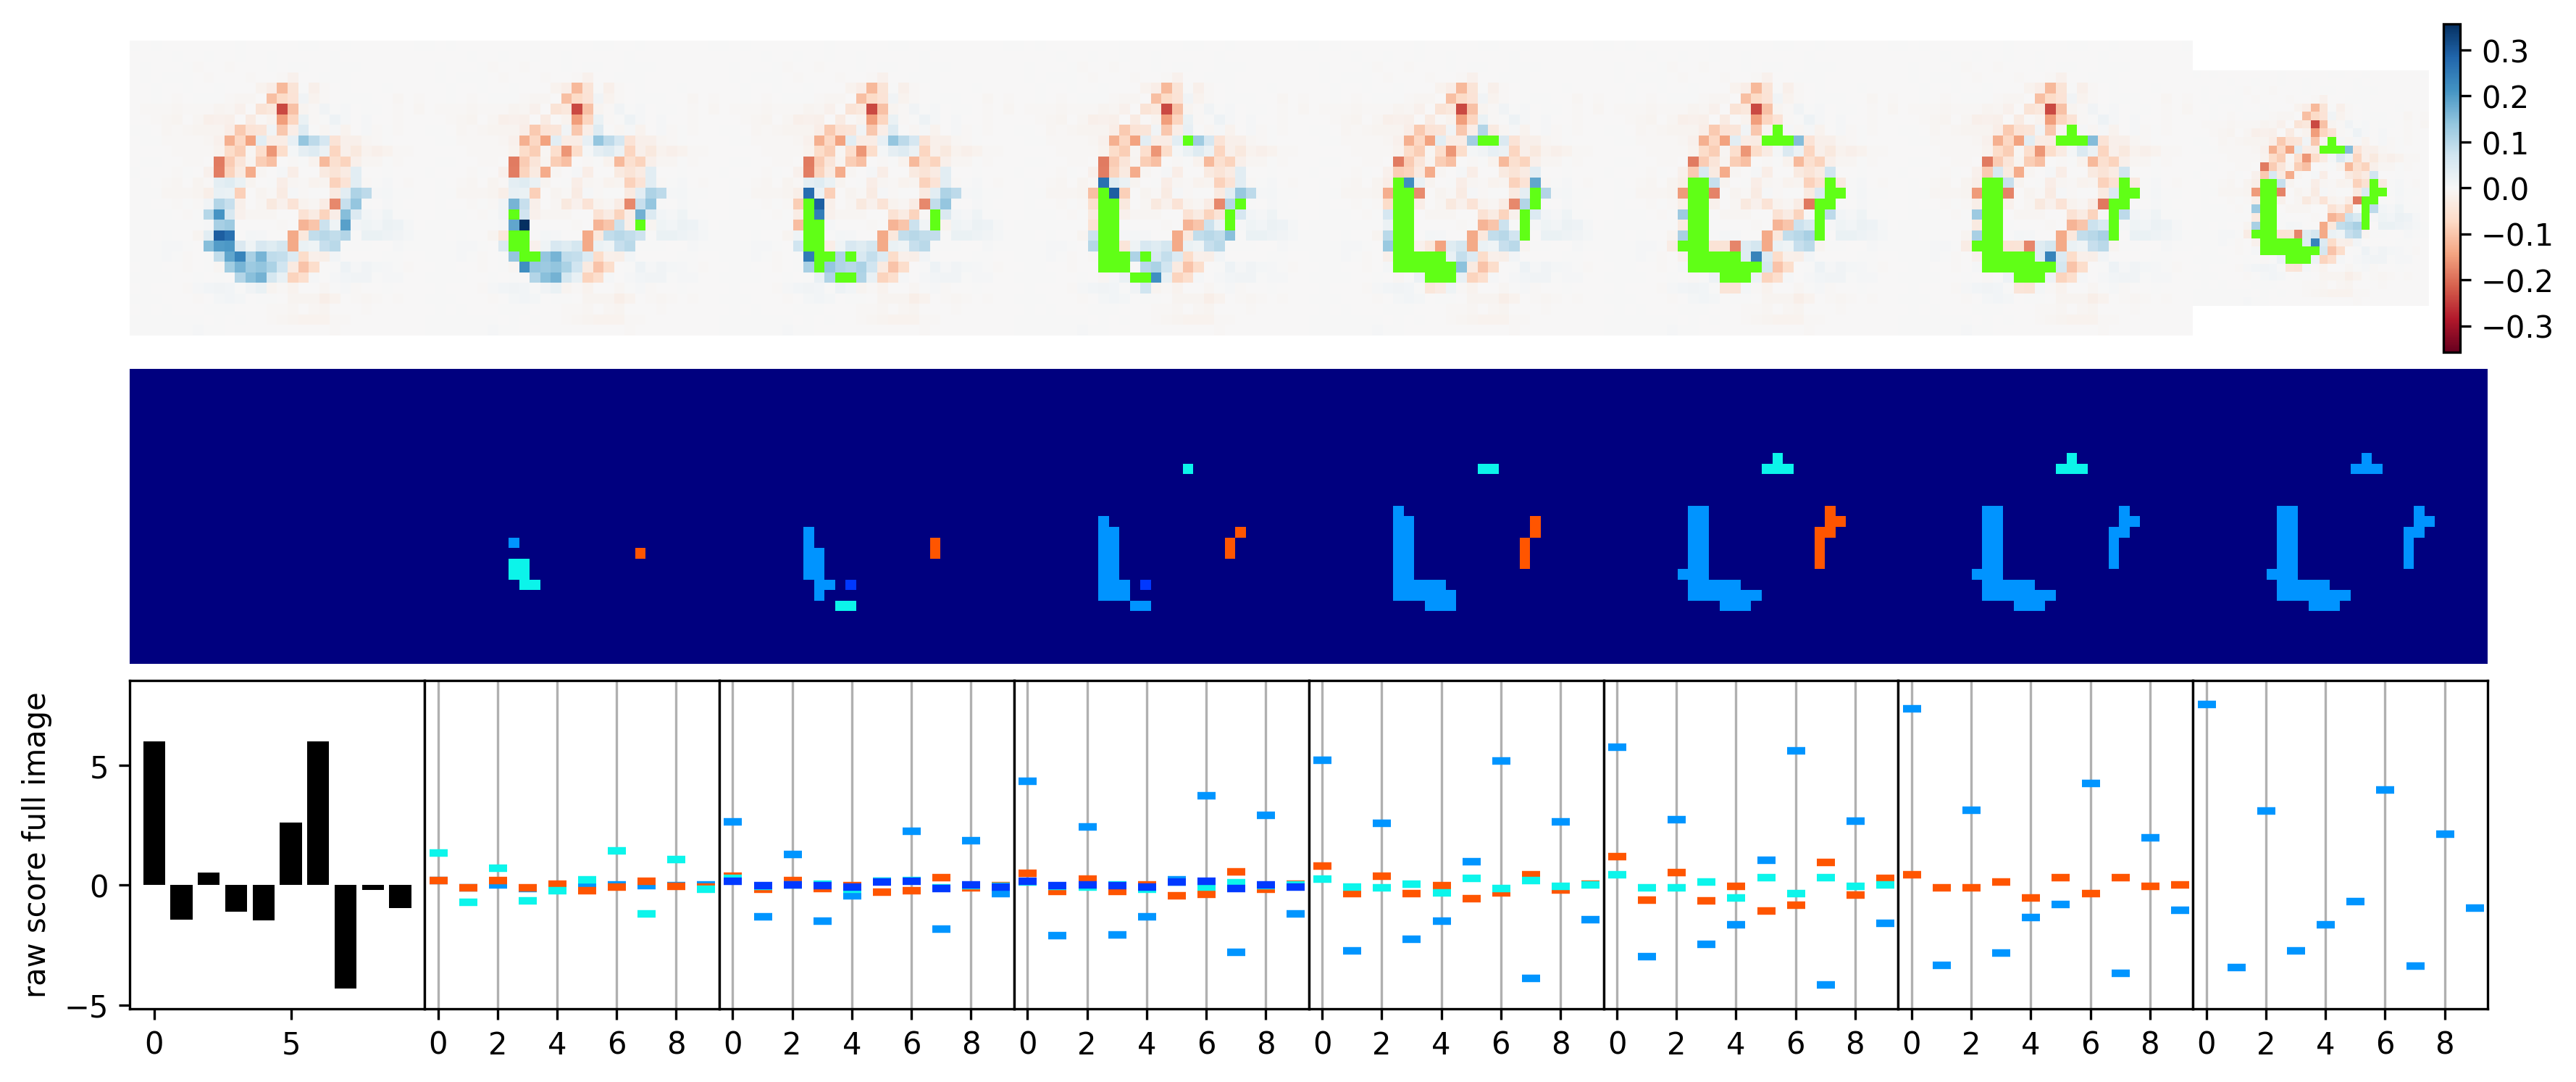

In [16]:
# agg params
method = 'cd'
percentile_include = 99
sweep_dim = 1
layer = 'softmax'
use_abs = False
num_iters = 5
im_num = 3
attack_type = 'deepfoolattack'

im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv = attack_im_num(dset, model, im_num, attack_type)

lists = agg.agglomerate(model, dset.pred_ims, percentile_include, 'cd', sweep_dim, layer, im_orig, 
                        model.predict(im_torch), use_abs, num_iters=num_iters, im_torch=im_torch, model_type='mnist')
        
# visualize original image
print('Original image')
rows=3
plt.figure(figsize=(14, 6), facecolor='white', dpi=300)
viz.visualize_ims_list(lists['scores_list'], 
                       cmap_new='redwhiteblue',
                       title='Refined scores',
                       subplot_row=0, subplot_rows=rows, colorbar=True)
viz.visualize_ims_list(lists['comps_list'],
                      title='blobs',
                      subplot_row=1, subplot_rows=rows, colorbar=False)
viz.visualize_dict_list(lists['comp_scores_raw_list'], method,
                       subplot_row=2, subplot_rows=rows)
plt.show()

lists = agg.agglomerate(model, dset.pred_ims, percentile_include, 
                'cd', sweep_dim, layer, im_orig_adv, 
                model.predict(im_torch), use_abs, num_iters=num_iters, 
                im_torch=im_torch_adv, model_type='mnist')

# visualize
print('Adversarial image')
rows=3
plt.figure(figsize=(14, 6), facecolor='white', dpi=300)
viz.visualize_ims_list(lists['scores_list'], 
                       cmap_new='redwhiteblue',
                       title='Refined scores',
                       subplot_row=0, subplot_rows=rows, colorbar=True)
viz.visualize_ims_list(lists['comps_list'],
                      title='blobs',
                      subplot_row=1, subplot_rows=rows, colorbar=False)
viz.visualize_dict_list(lists['comp_scores_raw_list'], method,
                       subplot_row=2, subplot_rows=rows)
plt.show()